# Change Detection

## Introduction

Detecting change in the environment is one of the most basic and important activities scientists can pursure.

Doing this sort of work in the field can be costly and challenging, particularly in remote areas because it requires repeat visits. With climate change especially, we can see that changes can occur at rapid rates and on spatial scales that exceed our ability to keep up with field observations.

Remote sensing can save a lot of time and money in tackling these problems of detecting environmental change.



## Imports, Authentication & Initialization

In [1]:
# Import the necessary libraries
import ee
import numpy as np
import geemap
import datetime
from datetime import date
import ltgee
from ltgee import LandTrendr, LandsatComposite, LtCollection
import geopandas
import pandas

from scipy.stats import norm, gamma, f, chi2

In [2]:
# Authenticate and initialize this instance of GEE in Google Colab
## Follow the prompts and fill in authentication code
ee.Authenticate()
ee.Initialize(project = 'ee-cptcitrus-main')

## Fort McMurray Wildfires

Remote sensing has a long history of monitoring wildfires. There are a couple of indices that can help us to interpret wildfire spread, vulnerability, and impact, and a number of existing data products that can help in assessing wildfires.

The Horse River wildfire which devestated Fort McMurray, Alberta occured over the summer of 2016, forcing the evacuation of more than 80,000 people from their homes. The fire was not fully extingushed until more than a year later after it burned nearly 6000 square kilometres. The fire caused over 3 billion dollars in damage. ([CBC News Article](https://newsinteractives.cbc.ca/longform/fort-mcmurray-five-years-on-from-disaster))

Disasters such as this (widespread and long term) can warrant the use of remote sensing to observe the environmental impact.

### MODIS Burned Area Dataset

We can use pre-existing datasets to visualize wildfires. The MODIS Burned Area data product is a monthly, global gridded 500m product containing per-pixel burned-area and quality information. Each pixel in the primary BurnDate band contains the day of the year (0 to 366) on which the burn occurred.

This data product is created using MODIS surface reflectance data (250m resolution) coupled with the MODIS Active Fire data product (1km resolution). The combination of these datasets means the algorithm is adaptive to regional burn conditions and is therefore suitable for many environments. Updates to the process have resulted in improved detection of small fires, and expansion of the product to cover water bodies to capture offshore fires.

### Burn Extent

First, we are going to look at the burn extent of the Fort McMurrary fires using the MODIS Burned Area dataset.

In [3]:
# First we need to load the MODIS Burned Area Monthly Global 500m dataset
dataset = ee.ImageCollection('MODIS/061/MCD64A1')\
                  .filter(ee.Filter.date('2016-01-01', '2016-12-31'))

# Select the burndate band which has values from 0 to 366 (day of the year)
burnedArea = dataset.select('BurnDate')

# Colour the dataset from day 120 (April 29) and day 182 (June 30)
# These dates encompass the height of the Fort McMurray wildfire
burnedAreaVis = {'min': 120,'max': 182,'palette': ['orange', 'purple']}

In [4]:
# Create map object
Map = geemap.Map()

# Set center on Fort McMurray, Alberta
Map.setCenter(-111.37,56.80, 8)

# Add the burned area layer and call for map
Map.addLayer(burnedArea, burnedAreaVis, 'Burned Area 2016')
Map

Map(center=[56.8, -111.37], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

Note that the map above tells us absolutely nothing about the burn intensity - just the timing and location of the burn. The palette goes from orange (earlier DOY) to purple (later DOY).

Try playing with the visualization min/max and zooming out to look at other regions and where and when burns happen. Try also filtering the MODIS data for other years to see how the patterns change (or don't) across the world.

To get more detailed information about the impact of a fire, we can look at burn intensity using indices like NBR.

### Burn Severity

We're going use the MODIS Burned Area dataset to examine the burn severity at Fort McMurray, Alberta in the period before the 2016 wildfires and a period following.

Burn severity is a measure of how fire affects the functioning of the ecosystem in the area that has been burnt, or the degree to which an area is affected by burn.

An index which captures burn severity is the Normaized Burn Ratio (NBR). NBR is used to identify burned areas and provide a measure of severity. It is a ratio between the NIR and SWIR bands.

The code for this section was adapted from the United Nations Platform for Space-based Information for Disaster Management and Emergency Response (UN-SPIDER) burn processing procedure.

In [5]:
# Cloud masking function for L8

def cloudMaskL8(image):
  # Bits 3 and 5 are cloud shadow and cloud, respectively.
  cloudShadowBitMask = 1 << 3 #select the cloud shadow bit location
  cloudsBitMask = 1 << 5 # select the cloud bit location
  # Get the pixel QA band.
  qa = image.select('QA_PIXEL')
  # Both flags should be set to zero, indicating clear conditions.
  # this only keeps pixels were both the cloud and cloud shadow bits are set to 0
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
      .And(qa.bitwiseAnd(cloudsBitMask).eq(0))
  # Return the masked image, not scaled to reflectance, with the QA bands.
  return image.updateMask(mask)

#Function to apply scale factors
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True).addBands(
      thermal_bands, None, True
  )


#### Get Imagery and Create Mosaics

In [6]:
# Set up imagery collections
# Set timeframes for before and after the Fort McMurray Fires
prefire_start = '2015-06-01'
prefire_end = '2015-06-30'

postfire_start = '2016-06-01'
postfire_end = '2016-06-30'


# Set area around Fort McMurray
geometry = ee.Geometry.Polygon([[-112.29,56.14],[-109.82,56.14],[-109.82,57.14],[-112.29,57.14]])
area = ee.FeatureCollection(geometry)

# Set imagery collection
prefireImCol = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')\
                        .filterDate(prefire_start, prefire_end)\
                        .map(apply_scale_factors)\
                        .filterBounds(area)\
                        .map(cloudMaskL8)

postfireImCol = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')\
                        .filterDate(postfire_start, postfire_end)\
                        .map(apply_scale_factors) \
                        .filterBounds(area)\
                        .map(cloudMaskL8)

In [7]:
# Create composite mosaics from pre and post time periods
pre_mos = prefireImCol.median().clip(area)
post_mos = postfireImCol.median().clip(area)

#### Calculating the NBR

In [8]:
# Calculate NBR
preNBR = pre_mos.normalizedDifference(['SR_B5', 'SR_B7'])
postNBR = post_mos.normalizedDifference(['SR_B5', 'SR_B7'])

In [9]:
# Let's plot our pre and post NBR images
# Set up map and visualization parameters
Map = geemap.Map()

L8vis = {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.8, 'gamma': 2}
greyscale = ['white','black']

## Add layers to map
Map.addLayer(pre_mos, L8vis,'Pre-fire True Color Image - Clouds masked')
Map.addLayer(post_mos, L8vis,'Post-fire True Color Image - Clouds masked')

Map.addLayer(preNBR, {'min': -1, 'max': 1, 'palette': greyscale}, 'Prefire Normalized Burn Ratio');
Map.addLayer(postNBR, {'min': -1, 'max': 1, 'palette': greyscale}, 'Postfire Normalized Burn Ratio');

# Set map parameters and load map
Map.centerObject(area,9)
Map.addLayerControl()
Map

Map(center=[56.64390364033026, -111.05499999999995], controls=(WidgetControl(options=['position', 'transparent…

Flip between the pre and post NBR layers and the pre and post image mosaics. What differences do you notice?

#### Calculating the dNBR

Next we're going to calculate delta NBR (dNBR) which is the difference between the pre-fire NBR and the post-fire NBR images we created earlier. This will produce a classification where the amount of change represents the burn severity.

In [10]:
# Calculate dNBR (delta NBR) by subtracting the post-burn from the pre-burn values
dNBR_unscaled = preNBR.subtract(postNBR)
dNBR = dNBR_unscaled.multiply(1000) # Scale by 1000 to USGS standards

In [11]:
# Plot all layers on map (pre TC, post TC, pre NBR, post NBR, dNBR)
# Set up map and visualization parameters
Map = geemap.Map()

# We need to define an additional visualization parameter
# We want to view the dNBR with an approximation of the USGS dNBR categorical colour scheme
colours = ["#ffffff","#7a8737","#acbe4d","#0ae042","#fff70b","#ffaf38","#ff641b","#a41fd6"]

## Add layers to map
Map.addLayer(pre_mos, L8vis,'Pre-fire True Color Image - Clouds masked')
Map.addLayer(post_mos, L8vis,'Post-fire True Color Image - Clouds masked')

Map.addLayer(preNBR, {'min': -1, 'max': 1, 'palette': greyscale}, 'Prefire Normalized Burn Ratio');
Map.addLayer(postNBR, {'min': -1, 'max': 1, 'palette': greyscale}, 'Postfire Normalized Burn Ratio');

Map.addLayer(dNBR, {'min': -500, 'max': 1000, 'palette': greyscale}, 'dNBR Greyscale')
Map.addLayer(dNBR, {'min': -500, 'max': 1000, 'palette': colours}, 'dNBR Coloured')

# Set map parameters and load map
Map.centerObject(area,9)
Map.addLayerControl()
Map

Map(center=[56.64390364033026, -111.05499999999995], controls=(WidgetControl(options=['position', 'transparent…

Use the legend below to interpret the grey and coloured dNBR scaled layers in the map you just created.

Note that the dNBR colour scale in the above map layer with the coloured palette does not properly match the accepted USGS categorical dNBR range because it is a continuous, rather than categorical, colour scale.

**dNBR Severity Legend**
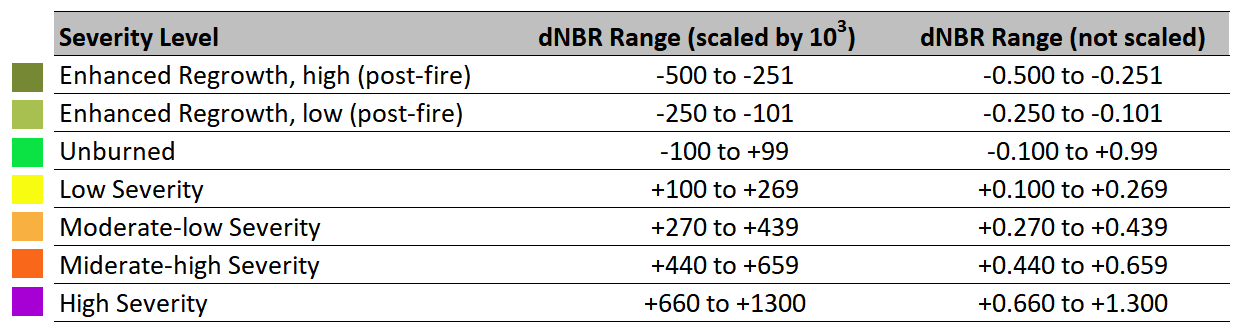

##### Using Styled Layer Descriptors

The continuous colour scheme approximation is used because Google Earth Engine does not handle categorical colour scales as well as continuous scales. They *do* have an option for using SLD (Styled Layer Descriptors) for styling (see code chunk below), but the code is a bit buggy in Google Colab and often causes the map to not load properly.

Check out the same code piece in the code editor [here](https://code.earthengine.google.com/366d7d68f1d393702135993d4d9b5d6a) to see the use of the SLD styling in action.

In [12]:
## Styled Layer Descriptors (SLD) styling for dNBR
## Note that this code doesn't run properly, it is just here as an example

# Define sld intervals
sld_intervals = """
<RasterSymbolizer>
  <ColorMap  type="intervals" extended="false" >
    <ColorMapEntry color="#ffffff" quantity="-500" label="-500"/>
    <ColorMapEntry color="#7a8737" quantity="-250" label="-250"/>
    <ColorMapEntry color="#acbe4d" quantity="-100" label="-100"/>
    <ColorMapEntry color="#0ae042" quantity="100" label="100"/>
    <ColorMapEntry color="#fff70b" quantity="270" label="270"/>
    <ColorMapEntry color="#ffaf38" quantity="440" label="440"/>
    <ColorMapEntry color="#ff641b" quantity="660" label="660"/>
    <ColorMapEntry color="#a41fd6" quantity="2000" label="2000"/>
  </ColorMap>
</RasterSymbolizer>"""

# Add layer to map with sld applied
Map.addLayer(dNBR.sldStyle(sld_intervals), {}, 'dNBR classified')
Map

Map(center=[56.64390364033026, -111.05499999999995], controls=(WidgetControl(options=['position', 'transparent…

## Glaciers

Like we saw in Lab 2 when we visualized change using composites and mosaicks, change can occur across many spatial and temporal scales.

Sometimes the change we are interested in detecting occurs over short periods of time (days or weeks) such as wildfires or other natural disasters. Other times, the change we're examining occurs over long periods of time (months, years, even decades) such as urban expansion.

We're going to explore the same example from Lab 2 of the Columbia Glacier, Alaska. This time we are going to implement a threshold to indicate where change has occured and what type of change has occured so that we can more easily identify and analyze it.

In [13]:
# Define geometry around the Columbia Glacier, Alaska
aoi = ee.Geometry.Polygon([[-147.35,60.90],[-146.72,60.90],[-146.72,61.17],[-147.35,61.17]])

# Get a 2015 image over Columbia Glacier
s1_preimage = ee.ImageCollection('COPERNICUS/S1_GRD')\
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
                .filter(ee.Filter.eq('instrumentMode', 'IW')) \
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) \
                .filterBounds(aoi) \
                .filterDate('2015-01-01','2015-01-31') \
                .first()

# Get a 2020 image over Columbia Glacier
s1_postimage = ee.ImageCollection('COPERNICUS/S1_GRD')\
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
                .filter(ee.Filter.eq('instrumentMode', 'IW')) \
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) \
                .filterBounds(aoi) \
                .filterDate('2020-01-01','2020-01-31') \
                .first()

We're only going to work with one band for simplicities sake, but there are methods that will incorporate change across multiple bands.

In [14]:
# Select VV bands only
s1_preimage = s1_preimage.select('VV')
s1_postimage = s1_postimage.select('VV')

In [15]:
## This code was adapted from "Detecting Changes in Sentinel-1 Imagery" by mortcanty
## https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-2#the_likelihood_ratio_test




# Likelihood Ratio Tests
# We are determining the backscatter change between the pre and post images, and representing it as a ratio
q1 = s1_preimage.divide(s1_postimage)
q2 = s1_postimage.divide(s1_preimage)

# Decision threshold
m = 5
dt = f.ppf(0.0005, 2*m, 2*m)

# Generate layer where:
  # no change = 0
  # decreased backscatter = 1
  # increased backscatter = 2
change = s1_preimage.multiply(0).where(q2.lt(dt),1)
change = change.where(q1.lt(dt),2)

# Mask pixels with no change (0)
change = change.updateMask(change.gt(0))

# Visualization parameters where decrease (1) = blue, increase (2) = red
changevis = {
    'min': 1,
    'max': 2,
    'palette': ['blue', 'red']
}

# Visualize the VV band images
s1vis = {
    'bands': ['VV','VV','VV'],
    'min': -20,
    'max': 0
}

Map = geemap.Map()
Map.addLayer(s1_preimage, s1vis, 's1 pre image')
Map.addLayer(s1_postimage, s1vis, 's1 post image')
Map.addLayer(change, changevis, 'Columbia Glacier Change')
Map.addLayerControl()
Map.centerObject(s1_preimage, 9)
Map

Map(center=[60.40021446757062, -149.27946178309475], controls=(WidgetControl(options=['position', 'transparent…

When we are interpreting this image, the important thing to keep in mind is that the "increase" and "decrease" is based on the ratio of backscatter between the two images. A glacier generally has lower backscatter than surrounding rock or exposed soil due to the specular reflectance of energy off of ice and snow. An increase in backscatter at a location means that melting and recession of the glacier has probably occurred, exposing underlying rocks and soil. A decrease means that perhaps there is more snow or ice cover at the location, smoothing over the rocks and soil, or maybe the glacier has advanced at the location.

In our result we mostly see red areas (increasing backscatter) which correlated with what we know (that the glacier is melting).

# Questions to Submit

## Q1 (1 point)

Provide an explanation of how remote sensing can be applied to detect short-term change and how it can be used to detect gradual change.

Provide an example of each (one that we didn't cover in this lab: wildfire, glacial melt).

// Your answer here
Short-term change is typically detectable based on a rapid chang in the spectral response of the area changing. This usually requires a sensor with a relatively short return interval (such as MODIS or VIIRS) to detect the change occuring even if clouds obscure several observations. Alternately, a sensor unaffected by clouds (e.g. SAR) may be able to detect the change even in the presence of clouds. An example of a short-term change may be pine-beetle kill in the interior forests of BC. Although the initial pine beetle impact can be very difficult to detect with remote sensing, the trees rapidly turn red, which is detectable in optical imagery.

Gradual change requires a time series of observations to remove other trends, such as seaonal defoliation or snowmelt. Arctic greening and treeline advance (at high elevation or high latitudes) due to climate change may represent such gradual changes. Imagery such as landsat-derived NDVI or LAI can be used to detect these gradual changes, but only once they have been detrended to remove seasonal variation, and also any short-term disturbances such as landslides or wildfires are masked out.

## Q2 (1 point)

We discussed some of the benefits of using remote sensing to monitor the environment. What about the downsides?

Explain **2 cases** where remote sensing would **not** be useful for detecting change and **why**.



// My answer
Sometimes the phenomenon of interest is not detectable using the spectra which are available from remote sensing. For example, Lianas are parasitic vines which are detrimental to rainforest health, but are very difficult to detect via remote sensing. This has confounded the ability of land managers to use remote sensing for monitoring their spread.

Another limitation of remote sensing is that clouds can obscure important observations. Wildfires are particularly problematic because their management requires repeated monitoring but they are produce oscuring smoke.

## Q3 (1 point)

Implement the above workflow for change detection and change direction identification for the Peyto Glacier, Banff National Park, Alberta (-116.5609, 51.6828) from 2015 to 2021.

Display your results on a map, along with the VV images, and a point representing the AOI. Briefly describe the changes you've identified.

In [31]:
# Show your code here
peyto = ee.Geometry.Point([-116.5609, 51.6828])

s1_preimage = ee.ImageCollection('COPERNICUS/S1_GRD')\
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
                .filter(ee.Filter.eq('instrumentMode', 'IW')) \
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) \
                .filterBounds(peyto) \
                .filterDate('2015-01-01','2015-01-31') \
                .first()

s1_postimage = ee.ImageCollection('COPERNICUS/S1_GRD')\
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
                .filter(ee.Filter.eq('instrumentMode', 'IW')) \
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')) \
                .filterBounds(peyto) \
                .filterDate('2021-01-01','2021-01-31') \
                .first()
s1_preimage = s1_preimage.select('VV')
s1_postimage = s1_postimage.select('VV')

## https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-2#the_likelihood_ratio_test
q1 = s1_preimage.divide(s1_postimage)
q2 = s1_postimage.divide(s1_preimage)

# Decision threshold
m = 5
dt = f.ppf(0.0005, 2*m, 2*m)

  # no change = 0
  # decreased backscatter = 1
  # increased backscatter = 2
change = s1_preimage.multiply(0).where(q2.lt(dt),1)
change = change.where(q1.lt(dt),2)

# Mask pixels with no change (0)
change = change.updateMask(change.gt(0))


In [32]:

# Visualization parameters where decrease (1) = blue, increase (2) = red
changevis = {
    'min': 1,
    'max': 2,
    'palette': ['blue', 'red']
}

# Visualize the VV band images
s1vis = {
    'bands': ['VV','VV','VV'],
    'min': -20,
    'max': 0
}

Map = geemap.Map()
Map.addLayer(s1_preimage, s1vis, 's1 pre image')
Map.addLayer(s1_postimage, s1vis, 's1 post image')
Map.addLayer(change, changevis, 'Peyto Glacier Change')


#Its hard to see the glacier, style a point
pointStyle = {
  'color': 'FF0000',
  'pointSize': 10, 
  'pointShape': 'circle',
  'opacity': 1     
}

Map.addLayer(peyto, pointStyle, 'Peyto Glacier')
Map.addLayerControl()
Map.centerObject(peyto, 14)
Map

Map(center=[51.6828, -116.5609], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

// Write your answer here
The Peyto glacier apears to be shrinking, and the modern OpenStreetMap base layer reflects the modern extent instead of the original extent.

## Q4 (1 point)

Research a fire or series of fires in Canada or the United States between 2016 and present.

Create a dNBR classified image for the fire(s) of your choice using the continuous USGS dNBR colour scheme we used in the example above. Provide a brief explanation of the burn severity of the fire(s) of interest.

Make sure you identify what fire event you are examining (where, when) and name your variables and layers appropriately to help with interpretation.

In [33]:
# Show your code here

ftsmith = ee.Geometry.Polygon([[-112.98402771817734,59.43936056975436],\
[-110.80873474942734,59.43936056975436], \
[-110.80873474942734,60.61380860508912], \
[-112.98402771817734,60.61380860508912]])

prefire_start = '2023-06-01'
prefire_end = '2023-06-30'

postfire_start = '2023-09-14'
postfire_end = '2023-10-10'

# Set imagery collection
prefireImCol = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')\
                        .filterDate(prefire_start, prefire_end)\
                        .map(apply_scale_factors)\
                        .filterBounds(ftsmith)\
                        .map(cloudMaskL8)

postfireImCol = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')\
                        .filterDate(postfire_start, postfire_end)\
                        .map(apply_scale_factors) \
                        .filterBounds(ftsmith)\
                        .map(cloudMaskL8)

In [34]:
#Calculate dNBR
pre_mos = prefireImCol.median().clip(ftsmith)
post_mos = postfireImCol.median().clip(ftsmith)

preNBR = pre_mos.normalizedDifference(['SR_B5', 'SR_B7'])
postNBR = post_mos.normalizedDifference(['SR_B5', 'SR_B7'])

dNBR_unscaled = preNBR.subtract(postNBR)
dNBR = dNBR_unscaled.multiply(1000) # Scale by 1000 to USGS standards

In [35]:
#Visualize
Map = geemap.Map()

colours = ["#ffffff","#7a8737","#acbe4d","#0ae042","#fff70b","#ffaf38","#ff641b","#a41fd6"]

## Add layers to map
Map.addLayer(pre_mos, L8vis,'Pre-fire True Color Image - Clouds masked')
Map.addLayer(post_mos, L8vis,'Post-fire True Color Image - Clouds masked')

Map.addLayer(preNBR, {'min': -1, 'max': 1, 'palette': greyscale}, 'Prefire Normalized Burn Ratio');
Map.addLayer(postNBR, {'min': -1, 'max': 1, 'palette': greyscale}, 'Postfire Normalized Burn Ratio');

Map.addLayer(dNBR, {'min': -500, 'max': 1000, 'palette': greyscale}, 'dNBR Greyscale')
Map.addLayer(dNBR, {'min': -500, 'max': 1000, 'palette': colours}, 'dNBR Coloured')

# Set map parameters and load map
Map.centerObject(ftsmith,12)
Map.addLayerControl()

In [36]:
#Categorized
# Define sld intervals
sld_intervals = """
<RasterSymbolizer>
  <ColorMap  type="intervals" extended="false" >
    <ColorMapEntry color="#ffffff" quantity="-500" label="-500"/>
    <ColorMapEntry color="#7a8737" quantity="-250" label="-250"/>
    <ColorMapEntry color="#acbe4d" quantity="-100" label="-100"/>
    <ColorMapEntry color="#0ae042" quantity="100" label="100"/>
    <ColorMapEntry color="#fff70b" quantity="270" label="270"/>
    <ColorMapEntry color="#ffaf38" quantity="440" label="440"/>
    <ColorMapEntry color="#ff641b" quantity="660" label="660"/>
    <ColorMapEntry color="#a41fd6" quantity="2000" label="2000"/>
  </ColorMap>
</RasterSymbolizer>"""

# Add layer to map with sld applied
Map.addLayer(dNBR.sldStyle(sld_intervals), {}, 'dNBR classified')
Map

Map(center=[60.02757337038698, -111.89638123380232], controls=(WidgetControl(options=['position', 'transparent…

In [22]:
geemap.ee_export_image_to_drive(
    image=lt,
    description='landtrendr_test',
    folder='gee',
    fileNamePrefix='landtrendr_test',
    region=kelowna_bbox,
    scale=30,
    crs='EPSG:4326',
    maxPixels=1e13
)

NameError: name 'lt' is not defined

## Q5 (1 point)

Find a vegetation disturbance (ex. Fire, Harvest, Landslide, Thaw Slumps, etc) in Canada or the United States between 1985 and present. You may use the fire or series of fires you investigated for Q4.

Using the LandTrendr Algorithm in the JavaScript API, create a disturbance map. Export the disturbance map as an asset and continue your analysis using GEE in Google Colab. Add the LandTrendr image to a map, and determine the year the disturbance was detected.

Using either Sentinel-2 or Landsat, find pre- and post-disturbance images and add them the map with the LandTrendr disturbance image. Describe the differences in landcover pre- and post-disturbance, and hypothesize what the disturbance was. Discuss how well LandTrendr was able to detect this disturbance.

In [37]:
dir(ltgee)

['LandTrendr',
 'LandsatComposite',
 'LtCollection',
 'Optional',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'calculate_median_diff',
 'count_clear_view_pixels',
 'datetime',
 'ee',
 'evi_transform',
 'forest_mask',
 'gee_utils',
 'landtrendr',
 'math',
 'nbr_transform',
 'ndfi_transform',
 'ndmi_transform',
 'ndsi_transform',
 'ndvi_transform',
 'standardize_collection',
 'tc_transform',
 'water_mask']

In [55]:



#tomahawk
coordinates = [
    [-114.97593418898894,53.35045750945467],
    [-114.76719395461394,53.35045750945467],
    [-114.76719395461394,53.46097926055868],
    [-114.97593418898894,53.46097926055868],
    [-114.97593418898894,53.35045750945467]
]

# Create a polygon feature using the coordinates
tomahawk_bbox = ee.Geometry.Polygon([coordinates])

# Initialize variables for LandTrendr algorithm
composite_params = {
    "start_date": date(2002, 2,1),
    "end_date": date(2023, 11,1),
    "area_of_interest": ee.Geometry({
        'type': 'Polygon',
        'coordinates': [coordinates]}),
    "mask_labels": ['cloud', 'shadow', 'snow', 'water'],
    "debug": True
}
lt_collection_params = {
        "sr_collection": LandsatComposite(**composite_params),
        # "sr_collection": composite_params, # - you may also just pass in your own collection or the params directly. Note: in the former, some methods in the class may not work.
        "index": 'NBR',
        "ftv_list": ['TCB', 'TCG', 'NBR'],
}
lt_params = {
    "lt_collection": LtCollection(**lt_collection_params),
    # "lt_collection": lt_collection_params, # - you may also just pass in your own collection or the params directly. Note: in the former, some methods in the class may not work.
    "run_params": {
            "maxSegments": 6,
            "spikeThreshold": 0.9,
            "vertexCountOvershoot":  3,
            "preventOneYearRecovery":  False,
            "recoveryThreshold":  0.25,
            "pvalThreshold":  .05,
            "bestModelProportion":  0.75,
            "minObservationsNeeded": 6,
        }
}

changeParams = {
 "delta":  'loss',
 "sort":   'greatest',
 "year":   {"checked":True, "start":2002, "end":2023},
 "mag":    {"checked":True, "value":100,  "operator":'>'},
 "dur":    {"checked":True, "value":4,    "operator":'<'},
 "preval": {"checked":True, "value":300,  "operator":'>'},
 "mmu":    {"checked":True, "value":11},
};

# Instantiating LandTrendr object. Note: The object will immediately request to run the algorithm on Google's servers.
lt = LandTrendr(**lt_params)
print(lt.getInfo())


{'type': 'Image', 'bands': [{'id': 'LandTrendr', 'data_type': {'type': 'PixelType', 'precision': 'double', 'dimensions': 2}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'ftv_tcb_fit', 'data_type': {'type': 'PixelType', 'precision': 'double', 'dimensions': 1}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'ftv_tcg_fit', 'data_type': {'type': 'PixelType', 'precision': 'double', 'dimensions': 1}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'ftv_nbr_fit', 'data_type': {'type': 'PixelType', 'precision': 'double', 'dimensions': 1}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'rmse', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}


In [56]:
lt1 = lt.get_change_map(changeParams)

palette = ['#9400D3', '#4B0082', '#0000FF', '#00FF00', '#FFFF00', '#FF7F00', '#FF0000'];
yod_vis_params = {
  'min': changeParams['year']['start'],
  'max': changeParams['year']['end'],
  'palette': palette
}
mag_vis_params = {
  'min': 0,
  'max': 800,
  'palette': palette
}

map = geemap.Map()
map.centerObject(composite_params['area_of_interest'], 13)
map.addLayer(lt1.select(['mag']), yod_vis_params, 'Magnitude of Change')
map.addLayer(lt1.select(['yod']), mag_vis_params, 'Year of Detection')
map.addLayer(composite_params['area_of_interest'], {}, 'area_of_interest')
map

Map(center=[53.405739956767924, -114.87156407180069], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:
geemap.ee_export_image_to_drive(
    image=lt1.select('yod'),
    description='landtrendr_Tomahawk_2000_2023',
    folder='gee',
    fileNamePrefix='landtrendr_Tomahawk_2000_2023',
    region=tomahawk_bbox,
    scale=30,
    crs='EPSG:4326',
    maxPixels=1e13
                    )

The imagery may not load in the Map above, depending on how quickly landtrendr is able to process the changes. The geemap export will almost certainly not work, but it has worked before, its just very slow.

In this case, landtrendr does a very poor job of detecting the land cover change. So does optical imagery. However, there are some detections of a "2021" or "2020" change which should reflect the tomahawk fire, but defining the false negatives will be a pain.